# Musical Genre Deep Learner

Spring 2021

Developers: Corey Blanke, Joseph Daau, Zachary Ellis

## Description

* For this Deep Learning project we are going to use spectrograph data sourced from Kaggle and using a ResNet, learn audio features. 
* The features learned from this model can then be used to enhance a machine learning model, for example a genre classifier. 
* We plan on using the GTZAN dataset which includes spectral data, and csv files with pre-extracted features of each song.

##Import Notice

From the shared drive for this project do the following steps

* Right click the "Data_Image/images_original" folder, select "Add Shortcut to drive" and then select "My Drive". This will create a reference to the folder in your drive in order to access the image files.



## Imports

Write all import statements here

In [19]:
from google.colab import drive
from os import listdir
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load and Prepare Data

 * We will be loading our datasets from our images_original folder and created our own dataset from them, 1 training and 1 testing.

 *testing set comprises 80% of the data and the validation is the remaining 20% of the data
 




In [20]:
# """Genre `Enum`"""
# Genre = {
#     "blues": "/content/drive/My Drive/images_original/blues/",
#     "classical": "/content/drive/My Drive/images_original/classical/",
#     "country": "/content/drive/My Drive/images_original/country/",
#     "disco": "/content/drive/My Drive/images_original/disco/",
#     "hiphop": "/content/drive/My Drive/images_original/hiphop/",
#     "jazz": "/content/drive/My Drive/images_original/jazz/",
#     "metal": "/content/drive/My Drive/images_original/metal/",
#     "pop": "/content/drive/My Drive/images_original/pop/",
#     "reggae": "/content/drive/My Drive/images_original/reggae/",
#     "rock": "/content/drive/My Drive/images_original/rock/"
# }

def Genre():
    """`Genre Generator-Fn:` Useful for iterating entire Data Directory
        `NOTE->` Use with a `for .. in Genre()` loop
    """
    yield "blues", "/content/drive/My Drive/images_original/blues/"
    yield "classical", "/content/drive/My Drive/images_original/classical/"
    yield "country", "/content/drive/My Drive/images_original/country/"
    yield "disco", "/content/drive/My Drive/images_original/disco/"
    yield "hiphop", "/content/drive/My Drive/images_original/hiphop/"
    yield "jazz", "/content/drive/My Drive/images_original/jazz/"
    yield "metal", "/content/drive/My Drive/images_original/metal/"
    yield "pop", "/content/drive/My Drive/images_original/pop/"
    yield "reggae", "/content/drive/My Drive/images_original/reggae/"
    yield "rock", "/content/drive/My Drive/images_original/rock/"


# load each image from every folder
images = {f[0]: [cv2.imread(f[1]+img) for img in listdir(f[1])] for f in Genre()}


# read the image data from our image oringinal directory, infer the labels from the folder
# we want them as string and split 80 -20, where the 20 is the validation set
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/images_original', # directory
    batch_size=20,
    image_size=(288, 432),
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    shuffle = True,
    seed=69420666
)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/images_original', # directory
    batch_size=20,
    image_size=(288, 432),
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    shuffle = False,
    seed=69420666 
)


# [tensor] - image dimensions [Height(`288`), Width(`432`), Channels(`rgb`)]
IMAGE_SHAPE = images["blues"][0].shape
# number of genres
OUTPUT = 10


print('\nDataSet:', dataset)
print('Image Shape:', IMAGE_SHAPE)
#print(images)

Found 999 files belonging to 10 classes.
Using 800 files for training.
Found 999 files belonging to 10 classes.
Using 199 files for validation.

DataSet: <BatchDataset shapes: ((None, 288, 432, 3), (None, 10)), types: (tf.float32, tf.float32)>
Image Shape: (288, 432, 3)


In [21]:
# function for getting number of filters
def get_filter_count(layer_idx, filters_root):
    return 2 ** layer_idx * filters_root

#Model Structure

* Taking in our images as input one at a time

* Feed the images into U-Net:
  * Part 1

    * 2x (3x3 Convolution with ReLU, unpadded) 
    * Copy the output from the 2 steps, and save it
    * maxpool 2x2

    * Repeat these 3 steps a total of 4 times
    * On the 5th time, we do 2x (3x3 Convolution with ReLU) following into Part 2

  * Part 2
    * up-convolution (upscale and a convoltuion of 2x2)

    * take the corresponding layers ouput (if we are on the bottom/last layer then for example take savedVal[savedVal.length -1]). This Concatinated Skip Connection (Tensorslow UNet import)

    * 2x (3x3 Convolution with ReLU)

    * repeat these three steps in part 2 till we get to the last value in our saved ouptuts

  * Part 3 
    * Feed into a decision layer and apply a softmax at the end in order to obtain our output




##U-Net Model Class


In [22]:
#Class for our Unet Calls
class Unet_Less_Complicated:
  
  #downsample function takes in the number of filters, kernel size, pool size and the activation function
  #it will do a 2d transpose
  #followed by 2 3x3 convolutions
  def DownSample(numFilters, kernel_Size, poolSize, activationFunc):

      model = keras.Sequential()
      model.add( keras.layers.Conv2D( filters= numFilters, kernel_size= (kernel_Size, kernel_Size), strides= 1, activation= activationFunc, padding= 'same' )  )
      model.add( keras.layers.Conv2D( filters= numFilters, kernel_size= (kernel_Size, kernel_Size), strides= 1, activation= activationFunc, padding= 'same' )  )

      model.add( keras.layers.SpatialDropout2D(0.5)  ) #try for dealing with overfitting

      model.add( keras.layers.MaxPool2D(  pool_size= (poolSize, poolSize ) ) )

      return model




  #upsample function takes in the number of filters, kernel size, pool size and the activation function
  #it will create a sequential model
  #it will do 2 convolutions, followed by a maxpool
  #return the model
  def UpSample(numFilters, kernel_Size, pool_size, activationFunc  ):

      model = keras.Sequential()
      model.add( keras.layers.Conv2DTranspose( filters= numFilters, kernel_size= (2, 2), strides= 2, activation= activationFunc, padding= 'same') )
      model.add( keras.layers.Conv2D( filters= numFilters, kernel_size= (kernel_Size, kernel_Size), strides= 1, activation= activationFunc, padding= 'same' )  )
      model.add( keras.layers.Conv2D( filters= numFilters, kernel_size= (kernel_Size, kernel_Size), strides= 1, activation= activationFunc, padding= 'same' )  )
      
      model.add( keras.layers.SpatialDropout2D(0.5)  ) #try for dealing with overfitting

      return model


  #inbetween function takes in the number of filters, kernel size, pool size and the activation function
  #inbetween is 2 convolution 
  def InBetween(numFilters, kernel_Size, pool_size, activationFunc ):

      model = keras.Sequential()
      model.add( keras.layers.Conv2D( filters= numFilters, kernel_size= (kernel_Size, kernel_Size), strides= 1, activation= activationFunc, padding= 'same' )  )
      model.add( keras.layers.Conv2D( filters= numFilters, kernel_size= (kernel_Size, kernel_Size), strides= 1, activation= activationFunc, padding= 'same' )  )

      model.add( keras.layers.SpatialDropout2D(0.5)  ) #try for dealing with overfitting

      return model



##Model for U-Net

In [23]:
# this function will be called using the 
# this function is called for each image we are using
def buildModel():
    # U-Net Model Instance


    # this will hold data for each completed convolution step
    down_Convolution_Holder = []
    up_Convolution_Holder = []
    concatinationStep = []
    layerIndex = 0
    layerSizeHolder = 0
    kernelSize=3
    pool_size=2
    layer_depth=5
    filters_root=32
    activation_func='relu'

    # Input Start
    inputInitial = tf.keras.Input(shape=(IMAGE_SHAPE), name="inputs" )

    #print("input shape after input is ", inputInitial.shape)
    #print("shape in the input is ", IMAGE_SHAPE)


    # PART 1 - run this 4 times
    for i in range(0, layer_depth - 1):
        # update # of filters
        filters = get_filter_count(i, filters_root)
        print(filters)

        # call the dowsample function in Unet, this will be generating the downsample model for us
        # save the WHAT the model is in order for us to get the WHERE later
        
        #down_Convolution_Holder.append( uNet.downsample(2, True, filters=filters // 2, pool_size=2))
        down_Convolution_Holder.append( Unet_Less_Complicated.DownSample(filters, kernelSize, pool_size, activation_func ) )

        layerSizeHolder +=1


    # 1 more iteration of 2x (3x3 Convolution with ReLU) this will get the next part of the model for us
    # inBetweenHolder is now a model reference 
    inBetweenHolder =  Unet_Less_Complicated.InBetween(filters//2, kernelSize, pool_size, activation_func)

    #print(layerSizeHolder)

    # Part 2 
    for i in range(layerSizeHolder, 0, -1):
        # update filters
        filters = get_filter_count(i, filters_root)
        print(filters)

        # get out holder model of upsample generation
        #up_Convolution_Holder.append(uNet.upsample(filters=filters // 2, pool_size=2))
        up_Convolution_Holder.append( Unet_Less_Complicated.UpSample(filters//2, kernelSize, pool_size, activation_func)   )



    # Assemble the Model
    x = inputInitial
    #print("initial shape ", x.shape)

    # downspample read through our model
    for down in down_Convolution_Holder:
        # apply a down-convolution to our model
        x = down(x)
        # get the value of the model's output to be stored for later
        concatinationStep.append(x)
        #print("after a down ", x.shape)
    #print(concatinationStep)


    # after down-convolution, do the in-between

    #print("before inbetween holder ", x.shape)
    x = inBetweenHolder(x)
    #print("inbetween x shape after  upconv is ", x.shape)


    # reverse our output of values
    concatinationStep = list( reversed(concatinationStep[:]) )
    #print(concatinationStep)

    # now we do the upsampleing
    # merge the two value together and we can read them both in the for loop
    for upConv, concat in zip(up_Convolution_Holder, concatinationStep):
      #print("before concat, x is ", x.shape )
      #print("before concat, concat is ", concat )
      
      # concatinate the concatination to the model!
      x = keras.layers.Concatenate()([x, concat])
      #print("x concat is ", x.shape)


      x = upConv(x) # do an up-convoltuion
      #print("x after upconv ", x.shape)

      

    #instead of this last convolution
    #we will instead do a Dense(10(number of classes))(might need to flatten)
    #flatten makes a vector to go into the dense, dense classifies based off the vector
    flat = keras.layers.Flatten()
    x = flat(x)

    dropout = keras.layers.Dropout(0.5)
    x = dropout(x)

    dense = keras.layers.Dense(10)

    x = dense(x)




    return tf.keras.Model(inputs=inputInitial, outputs=x)

#Training

* Split 80/20* *(Train/Test)*   *The data is missing 1 image for 1 Genre
* Shuffle the images
* tf.train(images, model, genres)

**Disclaimer:** *This clears ALL Model|Session cache*

DO NOT RUN THIS CELL IF THERE IS A SAVED VERSION OF THE CURRENT MODEL


##Build Model


32
64
128
256
512
256
128
64
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 288, 432, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 144, 216, 32) 10144       inputs[0][0]                     
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 72, 108, 64)  55424       sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 36, 54, 128)  221440      sequential_1[0][0]               
_________________________________________________________________

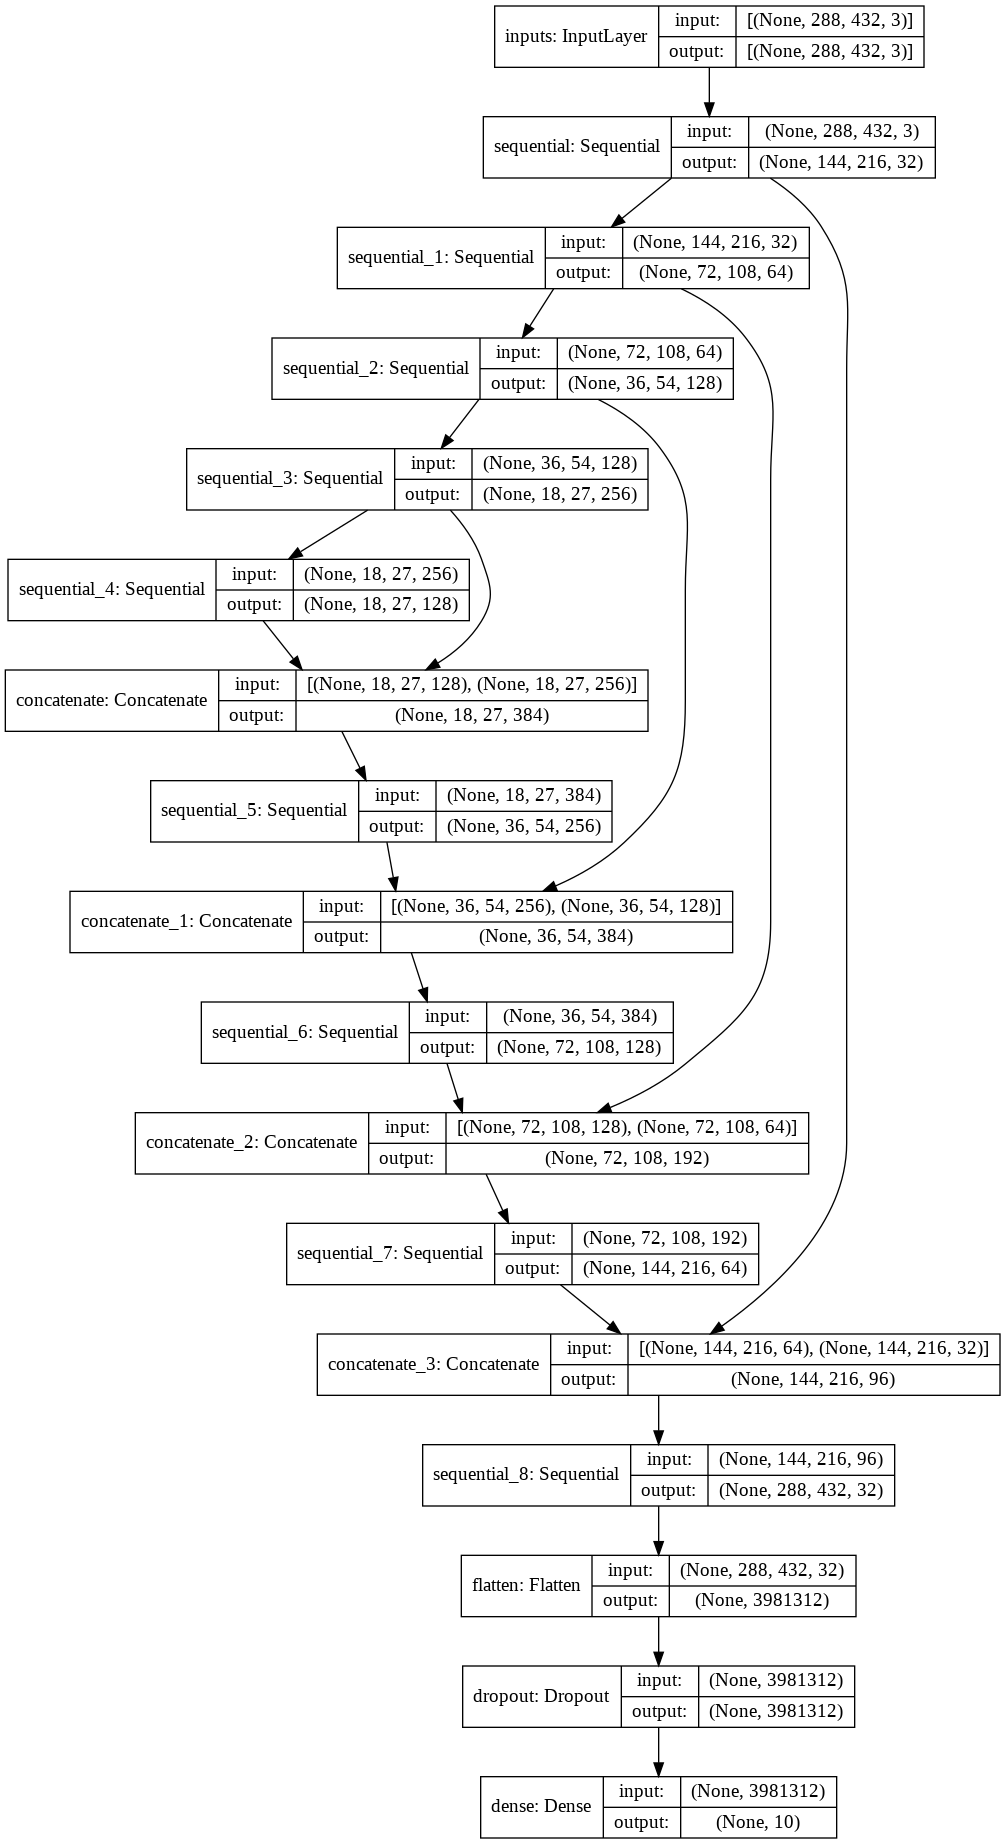

In [24]:
tf.keras.backend.clear_session()

# build the U-Net model
modelUnetLayers = buildModel()


# now we will make the RNN part to the u-net layers
# make sure unet works

modelUnetLayers.summary()
tf.keras.utils.plot_model(modelUnetLayers, show_shapes=True)

##Fit and train model


In [25]:
# fit and train the model now

# get the image data we will be using to fit in our model
#with our dataset (dataset has both the training and the testing data)
modelUnetLayers.compile(optimizer = Adam(lr = 1e-4), loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])
! mkdir '/content/drive/My Drive/logs'
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/logs')
results = modelUnetLayers.fit(dataset, epochs= 100 ,callbacks=[tensorboard_cb])



mkdir: cannot create directory ‘/content/drive/My Drive/logs’: File exists
Epoch 1/100
40/40 [==============================] - 68s 715ms/step - loss: 352.0562 - accuracy: 0.1130
Epoch 2/100
40/40 [==============================] - 28s 691ms/step - loss: 66.7616 - accuracy: 0.1766
Epoch 3/100
40/40 [==============================] - 29s 698ms/step - loss: 23.7694 - accuracy: 0.2476
Epoch 4/100
40/40 [==============================] - 29s 701ms/step - loss: 11.7906 - accuracy: 0.2989
Epoch 5/100
40/40 [==============================] - 29s 705ms/step - loss: 6.3669 - accuracy: 0.4273
Epoch 6/100
40/40 [==============================] - 29s 710ms/step - loss: 4.8090 - accuracy: 0.4526
Epoch 7/100
40/40 [==============================] - 29s 717ms/step - loss: 2.7787 - accuracy: 0.5591
Epoch 8/100
40/40 [==============================] - 29s 718ms/step - loss: 2.0985 - accuracy: 0.5873
Epoch 9/100
40/40 [==============================] - 30s 721ms/step - loss: 1.5702 - accuracy: 0.6672
Ep

##Evaluate Data

In [26]:
#test loss, test acc
modelUnetLayers.evaluate(dataset_test)


10/10 [==============================] - 6s 653ms/step - loss: 0.8522 - accuracy: 0.8945


[0.8522421717643738, 0.8944723606109619]

# Results

* Training accuracy and loss, 20 epochs
  * loss: 0.1247 - accuracy: 0.9606

* Testing accuracy and loss, 20 epochs
  * loss: 0.3998 - accuracy: 0.8894

* Training accuracy and loss, 30 epochs
  * loss: 0.0030 - accuracy: 0.9995

* Testing accuracy and loss, 30 epochs
  * loss: loss: 0.6203 - accuracy: 0.8844


* Training accuracy and loss, 100 epochs
  * loss: 0.0115 - accuracy: 0.9964

* Testing accuracy and loss, 100 epochs
  * loss: 0.8522 - accuracy: 0.8945

* Conclusion 
  * Increasing the number of epochs doesn't necessarily increase the accuracy of our current model after 20. If we wanted to increase our accuracy, we could impliment a stronger/deeper model with calls such as, regularization. Our model is able to accurately learn and depict which spectrograph belongs to which genre of music. 
  * Leaving the number of epochs at 100 for the presentation of this work

